In [1]:
import sys
sys.path.append("./scripts/")
from gridmap import *
import math
import copy
from matplotlib.animation import PillowWriter    #アニメーション保存用
theta_neigbors = np.array([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi, -3 * np.pi / 4, -np.pi / 2, -np.pi / 4])

In [2]:
class BUG():
    def __init__(self, world, drawMLine_flag=True):
        self.world = world
        self.m_line = np.array([])
        self.drawMLine_flag = drawMLine_flag
        self.takenPath = []
        
    def initialize(self):
        self.m_line = np.array([])
        self.alongObstacle = False
        self.prev_index = None
        self.prev_next_index = None
        self.prev_obs = None
        self.v = np.array([])
        self.takenPath = []
        
        self.currentIndex = self.world.start_index
        self.getMLine()
        self.mLine_min = float('inf')
        
    def draw(self, ax, elems):
        if(len(self.m_line) == 0):
            self.initialize()
            self.drawMLine(ax) if(self.drawMLine_flag is True) else None
        if self.world.isGoal(self.currentIndex):
            pass
        else:
            self.currentIndex = self.next(self.currentIndex)
            if not self.world.isGoal(self.currentIndex):
                self.world.drawGrid(self.currentIndex, "red", 0.5, ax)
    
    def plot(self, figsize=(4, 4), color="red", save_path=None, drawMLine_flag=False):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.world.grid_map):
            if grid == '0':
                self.world.drawGrid(index, "black", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal 
                self.world.drawGrid(index, "green", 1.0, ax)
        
        if(drawMLine_flag is True):
            for index in self.m_line:
                if (not self.world.isStart(index)) and (not self.world.isGoal(index)):
                    self.world.drawGrid(index, "lime", 0.5, ax)
        
        for index in self.takenPath:
            if (not self.world.isStart(index)) and (not self.world.isGoal(index)):
                self.world.drawGrid(index, color, 0.5, ax)
                    
        plt.show()

        if(save_path is not None):
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        return fig
    
    def run(self):
        self.initialize()
        while not self.world.isGoal(self.currentIndex):
            self.currentIndex = self.next(self.currentIndex)
            self.takenPath.append(self.currentIndex)
    
    def next(self, index):
        if np.all(index == self.prev_index):
            return self.prev_next_index
        self.prev_index = index
        next_index = None
        next_chk_index = None
        
        if(len(self.m_line) == 0):
            raise PathNotCalculatedError("Path did not calculate")
        
        # 過去に通過したM-Lineよりも近いM-Lineにに到達した場合
        if(np.any(np.all(self.m_line == index, axis=1)) and np.linalg.norm(index - self.world.goal_index) < self.mLine_min):
            self.alongObstacle = False
            next_chk_index = index
            dx, dy = index - self.world.goal_index
            theta_g = np.arctan2(dy, dx)
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_chk_index = index + neigbor_grids[neigbor_grid]
            self.mLine_min = np.linalg.norm(self.world.goal_index - index)
        
        # 前回，障害物がなかった場合
        if(self.alongObstacle is False):
            next_index = index
            dx, dy = index - self.world.goal_index
            theta_g = np.arctan2(dy, dx)
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = index + neigbor_grids[neigbor_grid]
            if(self.world.isObstacle(next_index)):
                self.alongObstacle = True
                next_index = self.moveCW(index, next_chk_index)
            else:
                self.mLine_min = np.linalg.norm(self.world.goal_index - index)
            self.v = index - next_index
            self.prev_next_index = next_index
            return next_index
        
        # 前回接触した障害物に隣接する障害物をリストアップ
        if self.world.isObstacle(self.prev_obs - self.v):
            next_index = self.moveCW(index, self.prev_obs - self.v)
        else:
            next_index = self.prev_obs - self.v
            if(np.all(np.abs(next_index - index) == [1, 1])):
                next_index = index - self.v
        self.v = index - next_index
        self.prev_next_index = next_index
        return next_index
    
    def getMLine(self):
        index = self.world.start_index
        self.m_line = np.array([index])
        while not self.world.isGoal(index):
            next_index = index
            dx, dy = index - self.world.goal_index
            theta_g = np.arctan2(dy, dx)
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = index + neigbor_grids[neigbor_grid]
            self.m_line = np.append(self.m_line, next_index.reshape(1, 2), axis=0)
            index = next_index
    
    def moveCW(self, index, next_chk_index):# 左回りになるように移動
        dxy = index - next_chk_index
        if(np.all(dxy == [1, 0]) or np.all(dxy == [1, 1])): # 障害物が左側または左下側の場合，下へ移動する
            if not self.world.isObstacle(index + [0, -1]):
                next_index = index + [0, -1]
                self.prev_obs = index + [-1, 0]
            elif not self.world.isObstacle(index + [1, 0]):
                next_index = index + [1, 0]
                self.prev_obs = index + [0, -1]
            elif not self.world.isObstacle(index + [0, 1]):
                next_index = index + [0, 1]
                self.prev_obs = index + [1, 0]
            else:
                next_index = index + [-1, 0]
        elif(np.all(dxy == [1, -1]) or np.all(dxy == [0, -1])): # 障害物が左上側または上側の場合，左へ移動する
            if not self.world.isObstacle(index + [-1, 0]):
                next_index = index + [-1, 0]
                self.prev_obs = index + [0, 1]
            elif not self.world.isObstacle(index + [0, -1]):
                next_index = index + [0, -1]
                self.prev_obs = index + [-1, 0]
            elif not self.world.isObstacle(index + [1, 0]):
                next_index = index + [1, 0]
                self.prev_obs = index + [0, -1]
            else:
                next_index = index + [0, 1]
        elif(np.all(dxy == [-1, 0]) or np.all(dxy == [-1, -1])): # 障害物が右側または右上側の場合，上へ移動する
            if not self.world.isObstacle(index + [0, 1]):
                next_index = index + [0, 1]
                self.prev_obs = index + [1, 0]
            elif not self.world.isObstacle(index + [-1, 0]):
                next_index = index + [-1, 0]
                self.prev_obs = index + [0, 1]
            elif not self.world.isObstacle(index + [0, -1]):
                next_index = index + [0, -1]
                self.prev_obs = index + [-1, 0]
            else:
                next_index = index + [1, 0]
        elif(np.all(dxy == [-1, 1]) or np.all(dxy == [0, 1])): # 障害物が下側または左下側の場合，右へ移動する
            if not self.world.isObstacle(index + [1, 0]):
                next_index = index + [1, 0]
                self.prev_obs = index + [0, -1]
            elif not self.world.isObstacle(index + [0, 1]):
                next_index = index + [0, 1]
                self.prev_obs = index + [1, 0]
            elif not self.world.isObstacle(index + [-1, 0]):
                next_index = index + [-1, 0]
                self.prev_obs = index ; [0, 1]
            else:
                next_index = index + [0, 1]
        return next_index
    
    def drawMLine(self, ax):
        for line in self.m_line:
            if not(self.world.isStart(line) or self.world.isGoal(line)):
                self.world.drawGrid(line, "lime", 0.5, ax)


class PathNotCalculatedError(Exception):
    pass

<IPython.core.display.Javascript object>


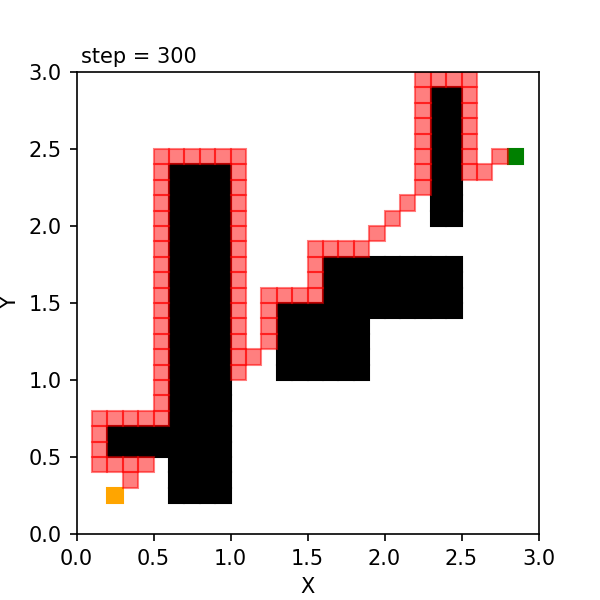

In [3]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "./csvmap/map7.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(BUG(world, drawMLine_flag=False))
    
    world.draw(figsize=(4, 4))
    #world.ani.save('bug_map.gif', writer='ffmpeg', fps=100)    #アニメーション保存